In [1]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#CountVectorizer --> Bag of words
#TfidfVectorizer --> Tf-IDF
#gensim.models.Word2Vec --> word embeddings (word2vec)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA





### Loading the dataset

In [43]:
df = pd.read_csv('reviews.csv')
df.head()

,Id,Review,Label
0,0,good and interesting,5
1,1,"This class is very helpful to me. Currently, I...",5
2,2,like!Prof and TAs are helpful and the discussi...,5
3,3,Easy to follow and includes a lot basic and im...,5
4,4,Really nice teacher!I could got the point eazl...,4


### Data preprocessing

In [44]:
def clean_text(text):
    #substituite the irrelevant characters
    text = re.sub(r'^[a-zA-Z\s]', '', text)
    #convert text to lower case
    text = text.lower()
    #tokenise the sentence in form of words
    tokens = word_tokenize(text)
    #set the stopwords for english language
    stop_words = set(stopwords.words('english'))
    #remove the stopwords
    filtered_tokens = [word  for word in tokens  if word not in stop_words]
    #applyign word net lemmatizer
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word)   for word in filtered_tokens]
    cleaned_text = ' '.join(lemmatized_tokens)
    return cleaned_text

df['cleaned_reviews'] = df['Review'].apply(clean_text)

df.to_csv('preprocessed_data.csv', index = False)
    
    

In [9]:
df.head()

,Id,Review,Label,cleaned_reviews
0,0,good and interesting,5,ood interesting
1,1,"This class is very helpful to me. Currently, I...",5,"class helpful . currently , 'm still learning ..."
2,2,like!Prof and TAs are helpful and the discussi...,5,ike ! prof ta helpful discussion among student...
3,3,Easy to follow and includes a lot basic and im...,5,asy follow includes lot basic important techni...
4,4,Really nice teacher!I could got the point eazl...,4,eally nice teacher ! could got point eazliy v


In [2]:
df = pd.read_csv('preprocessed_data.csv')
df.fillna('', inplace=True)

### Feature Extraction

In [3]:
X = df['cleaned_reviews']
Y = df['Label']

In [4]:
# bag of words
bow = CountVectorizer()
X_bow = bow.fit_transform(X)

In [5]:
# TF-IDF
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X)

In [ ]:
#Word2vec
sentences = [review.split() for review in X]
w2v = Word2Vec(
    window=10,
    min_count=1
)
w2v.build_vocab(sentences)
w2v.train(sentences, total_examples=w2v.corpus_count, epochs=w2v.epochs) #epochs -> number of times the model should do the iteration over given data

#save the model for further use 
w2v.save('./trained-word2vec-studentReviews.model')

In [38]:
w2v.save('D:/Study/College/IV Sem/Mini Project/Codes/Trained Models/trained-word2vec-studentReviews.model')

In [6]:
#load the model 
w2v = Word2Vec.load('./trained-word2vec-studentReviews.model')

In [7]:
#creating sentence vector:
def sentence_to_vector(sentence, model):
    words = sentence.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if not word_vectors:  # If the sentence contains no words in the model's vocabulary
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

# Create vectors for all sentences
X_vectors = np.array([sentence_to_vector(sentence, w2v) for sentence in X])

### PCA --> Principal component Analysis 
##### This is done in order to reduce dimension of vectors. It maximizes the variance and creates N components.

In [8]:
pca_model = PCA(n_components=50)
pca_model.fit(X_vectors)
pca_file = 'D:/Study/College/IV Sem/Mini Project/Codes/Trained Models/pca-model.sav'
pickle.dump(pca_model, open(pca_file, 'wb'))
X_vectors_pca = pca_model.transform(X_vectors)

### Splitting the dataset

In [9]:
#test_size = 0.2 --> 20% of the data goes for testing and the remaing 80% goes for traning
#random_state = 42 --> ensures that the data is split in the same random way across all code runs-> this ensures efficient debugging
X_train_bow, X_test_bow, Y_train, Y_test = train_test_split(X_bow, Y, test_size=0.2, random_state=42)
X_train_tfidf, X_test_tfidf,_, _ = train_test_split(X_tfidf, Y, test_size=0.2, random_state=42)
X_train_w2v, X_test_w2v,_, _ = train_test_split(X_vectors_pca, Y, test_size=0.2, random_state=42)


### Model Training

In [10]:
#naive bayes
#Gaussian Naive Bayes classifier can handle continuous data.
nb_bow = MultinomialNB()
nb_bow.fit(X_train_bow, Y_train)

nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, Y_train)

nb_w2v = GaussianNB()
nb_w2v.fit(X_train_w2v, Y_train)

#KNN
knn_bow = KNeighborsClassifier(n_neighbors=5)
knn_bow.fit(X_train_bow, Y_train)

knn_tfidf = KNeighborsClassifier(n_neighbors=5)
knn_tfidf.fit(X_train_tfidf, Y_train)

knn_w2v = KNeighborsClassifier(n_neighbors=5)
knn_w2v.fit(X_train_w2v, Y_train)


KNeighborsClassifier()

In [11]:
#SVM
#SVM performs better when the data is standarised or normalised, but in word2vec -> data is scaled
scaler = StandardScaler()

X_train_w2v_scaled = scaler.fit_transform(X_train_w2v)
X_test_w2v_scaled = scaler.fit_transform(X_test_w2v)

svm_bow = LinearSVC(dual=False, max_iter=10000)
svm_bow.fit(X_train_bow, Y_train)

svm_tfidf = LinearSVC(dual=False, max_iter=10000)
svm_tfidf.fit(X_train_tfidf, Y_train)

svm_w2v = LinearSVC(dual=False, max_iter=10000)
svm_w2v.fit(X_train_w2v_scaled, Y_train)

LinearSVC(dual=False, max_iter=10000)

### Model Evaluation

In [12]:
#Naive bayes
nb_pred_bow = nb_bow.predict(X_test_bow)
nb_pred_tfidf = nb_tfidf.predict(X_test_tfidf)
nb_pred_w2v = nb_w2v.predict(X_test_w2v)
#KNN
knn_pred_bow = knn_bow.predict(X_test_bow)
knn_pred_tfidf = knn_tfidf.predict(X_test_tfidf)
knn_pred_w2v = knn_w2v.predict(X_test_w2v)
#SVM
svm_pred_bow = svm_bow.predict(X_test_bow)
svm_pred_tfidf = svm_tfidf.predict(X_test_tfidf)
svm_pred_w2v = svm_w2v.predict(X_test_w2v)

print('Naive Bayes(Bag of Words) accurancy: ', accuracy_score(Y_test, nb_pred_bow))
print('Naive Bayes(TF-IDF) accurancy: ', accuracy_score(Y_test, nb_pred_tfidf))
print('Naive Bayes(Word2Vec) accurancy: ', accuracy_score(Y_test, nb_pred_w2v))
print()
print('KNN(Bag of Words) accurancy: ', accuracy_score(Y_test, knn_pred_bow))
print('KNN(TF-IDF) accurancy: ', accuracy_score(Y_test, knn_pred_tfidf))
print('KNN(Word2Vec) accurancy: ', accuracy_score(Y_test, knn_pred_w2v))
print()
print('SVM(Bag of Words) accurancy: ', accuracy_score(Y_test, svm_pred_bow))
print('SVM(TF-IDF) accurancy: ', accuracy_score(Y_test, svm_pred_tfidf))
print('SVM(Word2Vec) accurancy: ', accuracy_score(Y_test, svm_pred_w2v))


Naive Bayes(Bag of Words) accurancy:  0.7648103158288171
Naive Bayes(TF-IDF) accurancy:  0.7463091011025976
Naive Bayes(Word2Vec) accurancy:  0.682769575780228

KNN(Bag of Words) accurancy:  0.7352831246495982
KNN(TF-IDF) accurancy:  0.7336479162773314
KNN(Word2Vec) accurancy:  0.7293963745094375

SVM(Bag of Words) accurancy:  0.7602784526256774
SVM(TF-IDF) accurancy:  0.7728929172117361
SVM(Word2Vec) accurancy:  0.7579891609045039


### Saving the Trained Model

In [21]:
file1 = 'D:/Study/College/IV Sem/Mini Project/Codes/Trained Models/nb_bow.sav'
file2 = 'D:/Study/College/IV Sem/Mini Project/Codes/Trained Models/nb_tfidf.sav'
file3 = 'D:/Study/College/IV Sem/Mini Project/Codes/Trained Models/nb_w2v.sav'
pickle.dump(nb_bow, open(file1, 'wb'))
pickle.dump(nb_tfidf, open(file2, 'wb'))
pickle.dump(nb_w2v, open(file3, 'wb'))
file4 = 'D:/Study/College/IV Sem/Mini Project/Codes/Trained Models/knn_bow.sav'
file5 = 'D:/Study/College/IV Sem/Mini Project/Codes/Trained Models/knn_tfidf.sav'
file6 = 'D:/Study/College/IV Sem/Mini Project/Codes/Trained Models/knn_w2v.sav'
pickle.dump(knn_bow, open(file4, 'wb'))
pickle.dump(knn_tfidf, open(file5, 'wb'))
pickle.dump(knn_w2v, open(file6, 'wb'))
file7 = 'D:/Study/College/IV Sem/Mini Project/Codes/Trained Models/svm_bow.sav'
file8 = 'D:/Study/College/IV Sem/Mini Project/Codes/Trained Models/svm_tfidf.sav'
file9 = 'D:/Study/College/IV Sem/Mini Project/Codes/Trained Models/svm_w2v.sav'
pickle.dump(svm_bow, open(file7, 'wb'))
pickle.dump(svm_tfidf, open(file8, 'wb'))
pickle.dump(svm_w2v, open(file9, 'wb'))


### Result and Analysis

In [5]:
#load the trained models
file1 = 'D:/Study/College/IV Sem/Mini Project/Codes/Trained Models/nb_bow.sav'
file2 = 'D:/Study/College/IV Sem/Mini Project/Codes/Trained Models/nb_tfidf.sav'
file3 = 'D:/Study/College/IV Sem/Mini Project/Codes/Trained Models/nb_w2v.sav'
file4 = 'D:/Study/College/IV Sem/Mini Project/Codes/Trained Models/knn_bow.sav'
file5 = 'D:/Study/College/IV Sem/Mini Project/Codes/Trained Models/knn_tfidf.sav'
file6 = 'D:/Study/College/IV Sem/Mini Project/Codes/Trained Models/knn_w2v.sav'
file7 = 'D:/Study/College/IV Sem/Mini Project/Codes/Trained Models/svm_bow.sav'
file8 = 'D:/Study/College/IV Sem/Mini Project/Codes/Trained Models/svm_tfidf.sav'
file9 = 'D:/Study/College/IV Sem/Mini Project/Codes/Trained Models/svm_w2v.sav'
nb_bow = pickle.load(open(file1, 'rb'))
nb_tfidf = pickle.load(open(file2, 'rb'))
nb_w2v = pickle.load(open(file3, 'rb'))
knn_bow = pickle.load(open(file4, 'rb'))
knn_tfidf = pickle.load(open(file5, 'rb'))
knn_w2v = pickle.load(open(file6, 'rb'))
svm_bow = pickle.load(open(file7, 'rb'))
svm_tfidf = pickle.load(open(file8, 'rb'))
svm_w2v = pickle.load(open(file9, 'rb'))


In [32]:

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
d = {
    "Classifier" : ["Naive Bayes", "KNN", "SVM"],
    "BOW" : [accuracy_score(Y_test, nb_pred_bow), accuracy_score(Y_test, knn_pred_bow), accuracy_score(Y_test, svm_pred_bow)],
    "TF-IDF" : [accuracy_score(Y_test, nb_pred_tfidf), accuracy_score(Y_test, knn_pred_tfidf), accuracy_score(Y_test, svm_pred_tfidf)],
    "Word2Vec": [accuracy_score(Y_test, nb_pred_w2v), accuracy_score(Y_test, knn_pred_w2v), accuracy_score(Y_test, svm_pred_w2v)]
}

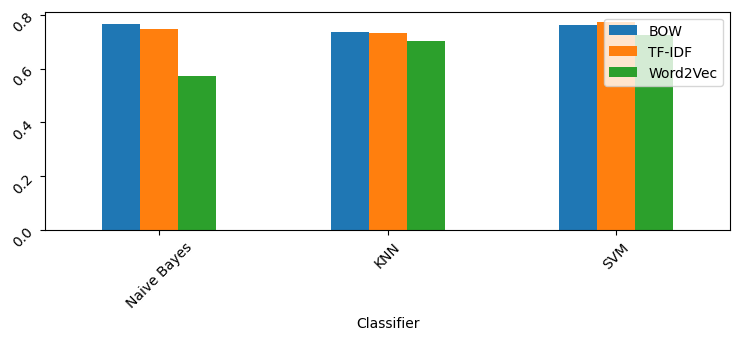

In [37]:
df2 = pd.DataFrame(d)
df2.set_index('Classifier').plot(kind="bar", align='center', width=0.5)
plt.tick_params(rotation = 45)

plt.show()